In [73]:
import json
import pathlib
import sys
from io import StringIO
from IPython.display import display, SVG

import svgwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(pathlib.Path().resolve().parents[1]))
from src.util.db_utils import SynFermDatabaseConnection
from src.util.color_palette import BodeColorPalette
from src.definitions import DATA_DIR

In [2]:
from lxml import etree
from lxml.builder import E

In [8]:
# import data from curated data set
df = pd.read_csv(DATA_DIR / "curated_data" / f"synferm_dataset_2023-12-20_39486records.csv")

In [9]:
len(df)

39486

In [10]:
df.head()

,I_long,M_long,T_long,product_A_smiles,I_smiles,M_smiles,T_smiles,reaction_smiles,reaction_smiles_atom_mapped,experiment_id,...,binary_H,scaled_A,scaled_B,scaled_C,scaled_D,scaled_E,scaled_F,scaled_G,scaled_H,major_A-C
0,2-Pyr003,Fused002,TerABT004,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1ccc(F)cc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56113,...,0,0.036021,0.003427,0.0,0.020975,0.002958,0.941981,0.914281,0.00000,A
1,2-Pyr003,Fused002,TerABT007,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1cc(Br)ccc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56114,...,0,0.000000,0.000000,0.0,0.006159,0.364398,0.928851,1.106548,0.00000,no_product
2,2-Pyr003,Fused002,TerABT013,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1cc(C(F)(F)F)ccc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56106,...,1,0.000000,0.000000,0.0,0.014212,2.166420,1.013596,0.537785,0.05686,no_product
3,2-Pyr003,Fused002,TerABT014,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,Nc1ccc(Cl)cc1S,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,56112,...,0,0.028915,0.005039,0.0,0.015578,0.504057,0.992614,0.890646,0.00000,A
4,2-Pyr003,Fused002,TerTH001,COc1ccc(CCOC(=O)N2C[C@H](NC(=O)c3cccc(Cl)n3)[C...,O=C(c1cccc(Cl)n1)[B-](F)(F)F.[K+],COc1ccc(CCOC(=O)N2C[C@@H]3NO[C@]4(OC5(CCCCC5)O...,[Cl-].[NH3+]NC(=S)c1ccccc1,O=C(c1cccc(Cl)n1)[B-](F)(F)F.COc1ccc(CCOC(=O)N...,F[B-](F)(F)[C:1](=[O:2])[c:11]1[cH:12][cH:14][...,56109,...,0,0.350061,0.643219,0.0,0.031689,0.613596,0.109309,0.439018,0.00000,B


In [26]:
df["major_A-C"].value_counts().sort_index()

A             21655
B              8680
C              3454
no_product     5697
Name: major_A-C, dtype: int64

In [27]:
def get_class(series):
    sorted_series = series.sort_values()  # sort so that ties will be broken in a consistent way
    most_frequent_value = sorted_series.value_counts().index[0]
    if most_frequent_value == "A":
        return "major-A"
    if most_frequent_value == "B":
        return "major-B"
    if most_frequent_value == "C":
        return "major-C"
    if most_frequent_value == "no_product":
        return "major-none"

In [28]:
x_axis = "Monomer"
y_axis = "Initiator"

In [29]:
x_index = np.sort(df[f"{x_axis[0]}_long"].unique())
y_index = np.sort(df[f"{y_axis[0]}_long"].unique())

In [30]:
# some settings for the plot
rect_x = 20
rect_y = 20
text_len = 80

x_total = len(x_index) * rect_x + text_len
y_total = len(y_index) * rect_y + text_len

# set root
svg = E.svg(viewBox=f"0 0 {x_total} {y_total}")

# set internal CSS styles
style = E.style("""
.major-A {
  fill: #5790fc;
  stroke: #729ef5;
}
.major-B {
  fill: #f89c20;
  stroke: #f6b45e;
}
.major-C {
  fill: #964a8b;
  stroke: #96638e;
}
.major-none {
  fill: #e42536;
  stroke: #de4e5b;
}
.axes {
  stroke: black; 
}
.axes-labels {
  fill: black;
  font-family: Helvetica, sans-serif;
  font-size: 12px;
  font-weight: bold;
}
""")
svg.append(style)

# set axes
#axes = E.g()
#axes.set("class", "axes")
#axes.append(E.line(x1=str(text_len), x2=str(x_total), y1=str(y_total - text_len), y2=str(y_total - text_len)))  # x-axis
#axes.append(E.line(x1=str(text_len), x2=str(text_len), y1="0", y2=str(y_total - text_len)))  # y-axis
#svg.append(axes)

# set axes labels
axes_labels = E.g()
axes_labels.set("class", "axes-labels")
x_labels = E.text(transform=f"translate({text_len} {2 * y_total}) rotate(-90)")
y_labels = E.text(x="0", y=str(rect_y))

# x-axis labels
for i_x, x_label in enumerate(x_index):
    tspan = E.tspan(x_label, y=str((i_x + 0.5) * rect_x), x=str(y_total))
    x_labels.append(tspan)

# y-axis labels
for i_y, y_label in enumerate(y_index):
    tspan = E.tspan(y_label, x="0", y=str((i_y + 0.5) * rect_y))
    y_labels.append(tspan)

# Append the tspan elements
axes_labels.append(x_labels)
axes_labels.append(y_labels)
svg.append(axes_labels)

# set heatmap squares
squares = E.g()

for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            offset_x = rect_x * i_x + text_len
            offset_y = rect_y * i_y
            square = E.rect(x=str(offset_x), y=str(offset_y), width=str(rect_x), height=str(rect_y), id=f"{x}_{y}")
            square.set("class", get_class(data["major_A-C"]))
            squares.append(square)
svg.append(squares)

# render to string
s = etree.tostring(svg, pretty_print=True)

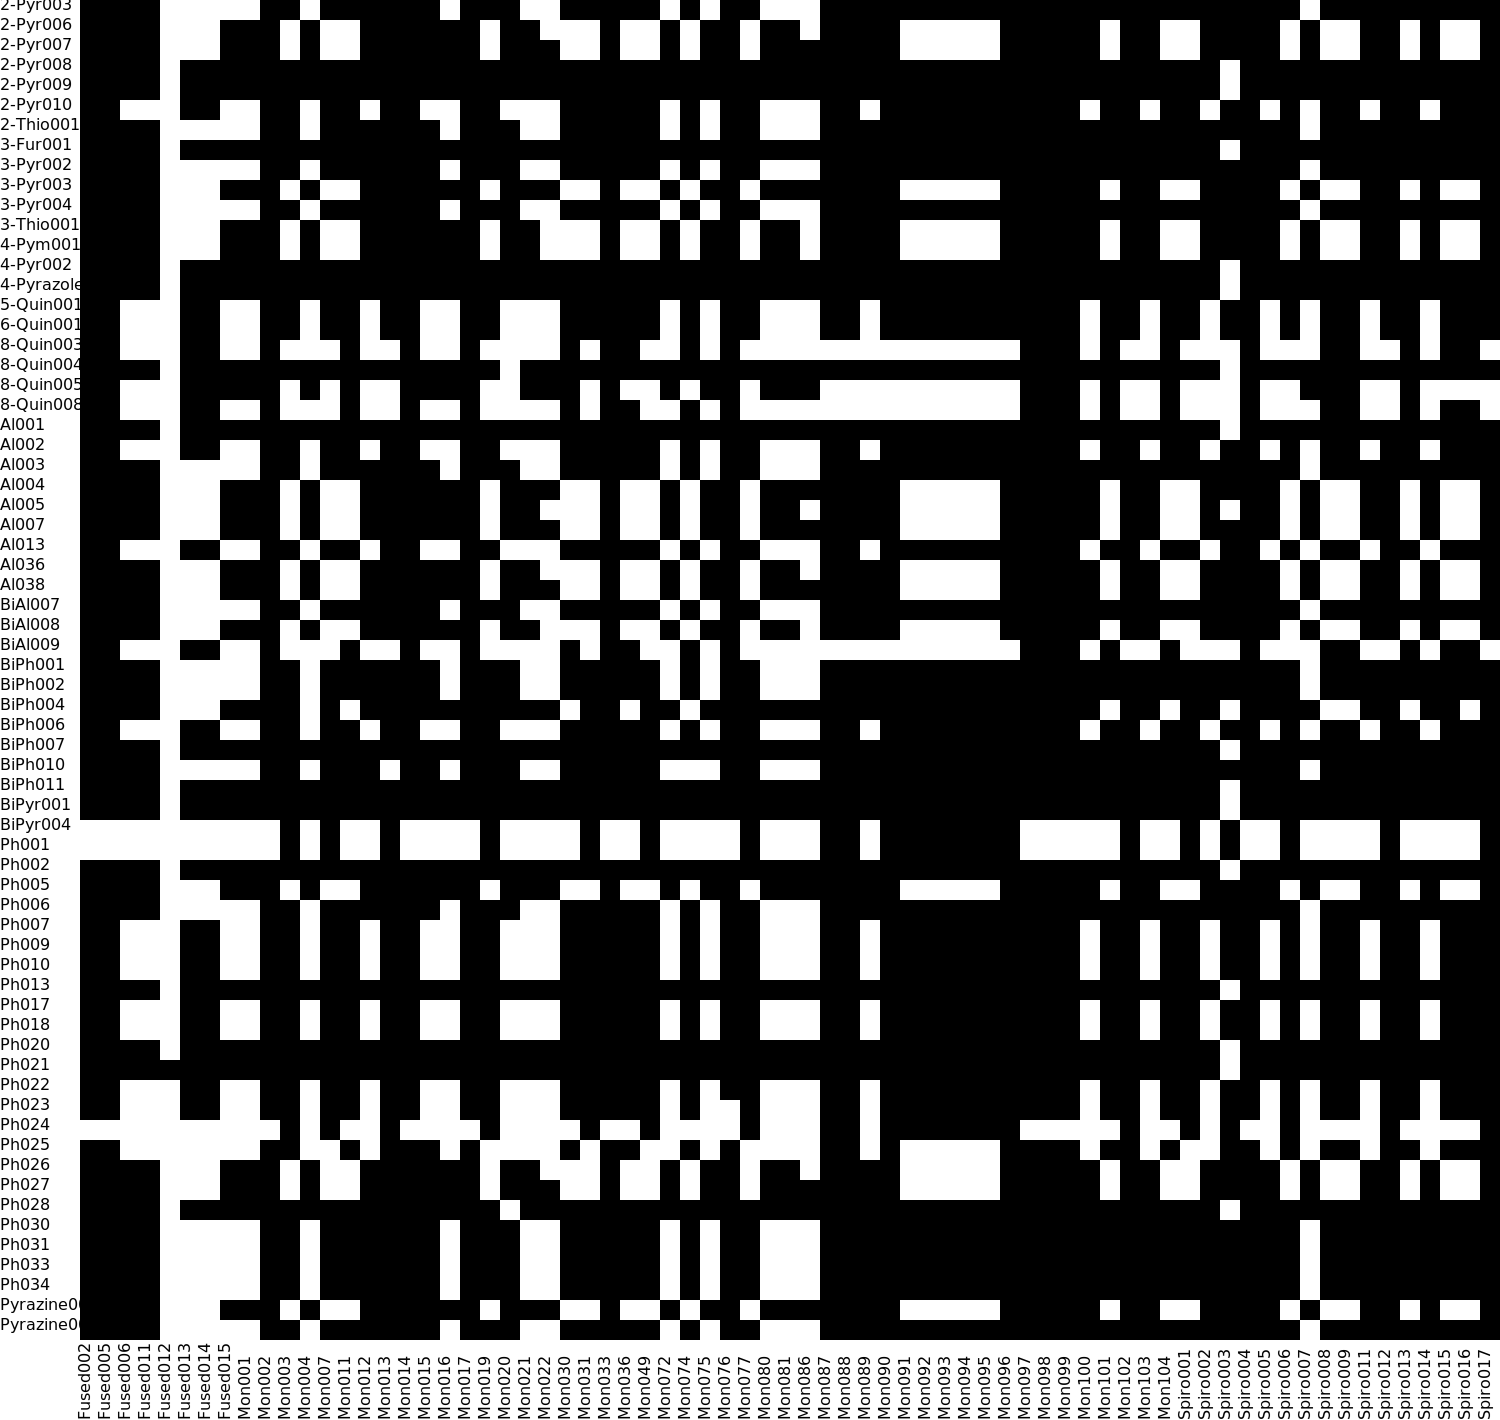

In [31]:
display(SVG(s))

In [32]:
with open("/Users/julian/Desktop/sf_heatmap_majorProduct.svg", "wb") as f:
    f.write(etree.tostring(svg, pretty_print=True))

In [33]:
# we will need a JSON dict to relate identifiers to data points / SVG images
relations = {}
for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        identifier = f"{x}_{y}"
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            filenames = [f"product_images/{row['I_long']}_{row['M_long']}_{row['T_long']}.svg" for i, row in data.iterrows()]
            major = [row['major_A-C'] for i, row in data.iterrows()]
        else:
            filenames = []
            major = {"A": 0, "B": 0, "C": 0, "none":0}
        relations[identifier] = {"filenames": filenames, "major": major}
            

In [ ]:
print(relations)

In [35]:
with open("svg-relations.json", "w") as f:
    json.dump(relations, f)

In [36]:
# now we produce the same heatmap, but for binary_A instead of major_A-C
def get_class(series):
    most_frequent_value = series.value_counts().index[0]
    if most_frequent_value == 1:
        return "success"
    if most_frequent_value == 0:
        return "fail"

In [37]:
x_axis = "Monomer"
y_axis = "Initiator"

x_index = np.sort(df[f"{x_axis[0]}_long"].unique())
y_index = np.sort(df[f"{y_axis[0]}_long"].unique())

# some settings for the plot
rect_x = 20
rect_y = 20
text_len = 80

x_total = len(x_index) * rect_x + text_len
y_total = len(y_index) * rect_y + text_len

# set root
svg = E.svg(viewBox=f"0 0 {x_total} {y_total}")

# set internal CSS styles
style = E.style("""
.success {
fill: #5790fc;
stroke: #729ef5;
}
.fail {
  fill: #e42536;
  stroke: #de4e5b;
}

.axes-labels {
  fill: black;
  font-family: Helvetica, sans-serif;
  font-size: 12px;
  font-weight: bold;
}
""")
svg.append(style)

# set axes labels
axes_labels = E.g()
axes_labels.set("class", "axes-labels")
x_labels = E.text(transform=f"translate({text_len} {2 * y_total}) rotate(-90)")
y_labels = E.text(x="0", y=str(rect_y))

# x-axis labels
for i_x, x_label in enumerate(x_index):
    tspan = E.tspan(x_label, y=str((i_x + 0.5) * rect_x), x=str(y_total))
    x_labels.append(tspan)

# y-axis labels
for i_y, y_label in enumerate(y_index):
    tspan = E.tspan(y_label, x="0", y=str((i_y + 0.5) * rect_y))
    y_labels.append(tspan)

# Append the tspan elements
axes_labels.append(x_labels)
axes_labels.append(y_labels)
svg.append(axes_labels)

# set heatmap squares
squares = E.g()

for i_x, x in enumerate(x_index):
    for i_y, y in enumerate(y_index):
        data = df.loc[(df[f"{x_axis[0]}_long"] == x) & (df[f"{y_axis[0]}_long"] == y)]
        if len(data) > 0:
            offset_x = rect_x * i_x + text_len
            offset_y = rect_y * i_y
            square = E.rect(x=str(offset_x), y=str(offset_y), width=str(rect_x), height=str(rect_y), id=f"{x}_{y}")
            square.set("class", get_class(data["binary_A"]))
            squares.append(square)
svg.append(squares)

# render to string
s = etree.tostring(svg, pretty_print=True)

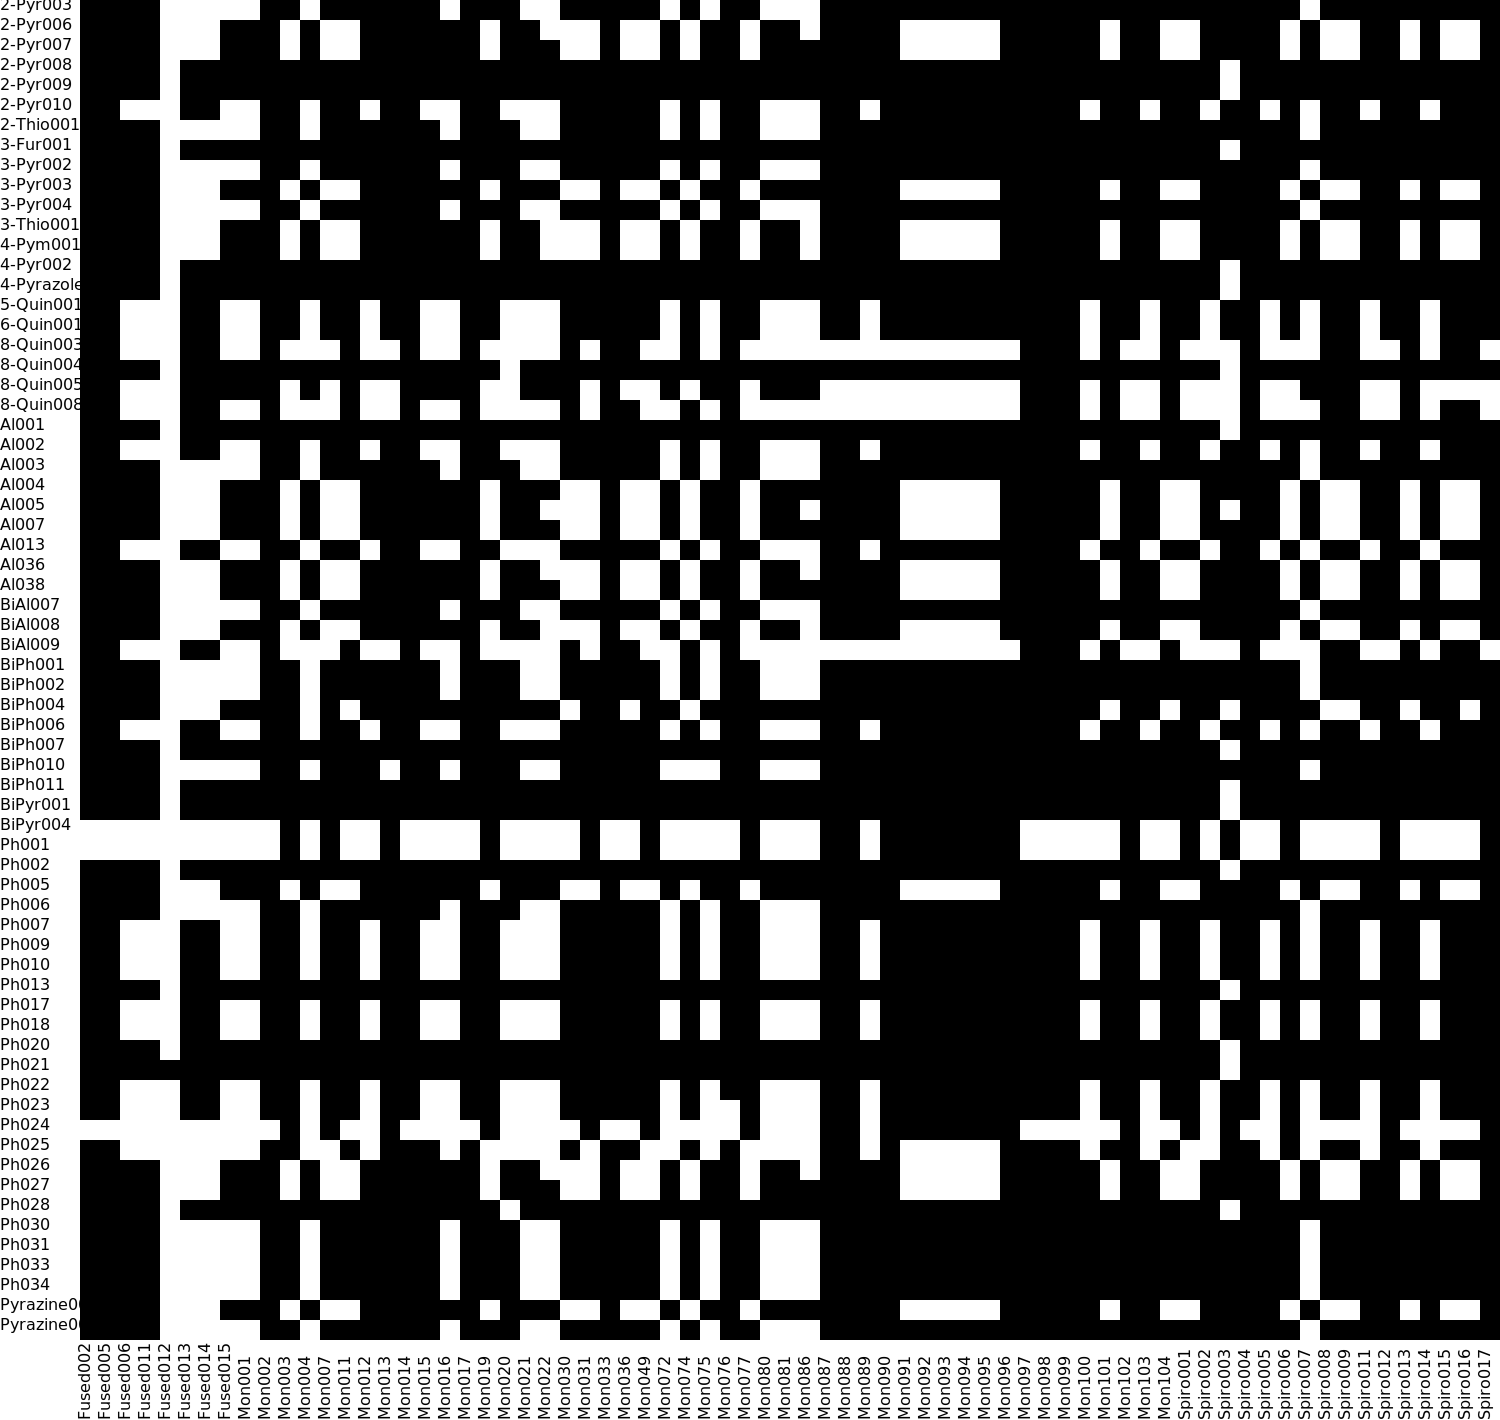

In [ ]:
display(SVG(s))

In [39]:
with open("/Users/julian/Desktop/sf_heatmap_2023-12-20_binary-A.svg", "wb") as f:
    f.write(etree.tostring(svg, pretty_print=True))

In [58]:
# while we are at it, get the statistics for success rates by product
df[[i for i in df.columns if i.startswith("binary_")]].mean()

binary_A    0.820848
binary_B    0.577521
binary_C    0.285392
binary_D    0.809148
binary_E    0.857165
binary_F    0.933141
binary_G    0.860786
binary_H    0.486375
dtype: float64

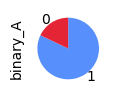

In [75]:
# while we are at it, get the statistics for success rates by product
df["binary_A"].value_counts().plot.pie(figsize=(1,1), colors=["#5790fc", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/binary-A_freq.svg")

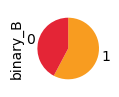

In [76]:
# while we are at it, get the statistics for success rates by product
df["binary_B"].value_counts().plot.pie(figsize=(1,1), colors=["#f89c20", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/binary-B_freq.svg")

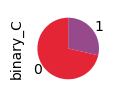

In [77]:
# while we are at it, get the statistics for success rates by product
df["binary_C"].value_counts().sort_index(ascending=False).plot.pie(figsize=(1,1), colors=["#964a8b", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/binary-C_freq.svg")

In [44]:
# also get the statistics on the main product
df["major_A-C"].value_counts() / len(df)

A             0.548422
B             0.219825
no_product    0.144279
C             0.087474
Name: major_A-C, dtype: float64

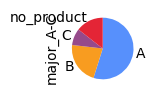

In [88]:
(df["major_A-C"].value_counts().sort_index() / len(df)).plot.pie(figsize=(1,1), colors=["#5790fc", "#f89c20", "#964a8b", "#e42536"], startangle=90, counterclock=False)
plt.savefig("/Users/julian/Desktop/major_A-C_freq.svg")